# Fairness Checking: Equalized Odds Constraint Experiment
This notebook uses PuLP to solve the linear program outlined in the "Fairness Checking" document. Here, **we experiment with varying the upper bound constraint on w and see its effects on the objective value.**

In [1]:
!pip install pulp

In [2]:
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt

In [3]:
# Run this cell to mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

## Import Predicted Data
We take A (the protected attribute) to be the 'race' variable, and a = 0 while a' = 1. The last column, 'prediction,' is our f(X) variable, which can either be 0 or 1.

In [4]:
algorithm_used = 'postprocessing' # preprocessing, inprocessing, postprocessing
pred_df = pd.read_csv('./../../predicted_data/{}/{}_logreg_adult_dp.csv'.format(algorithm_used, algorithm_used))

In [5]:
pred_df.head(5)

,Unnamed: 0,Unnamed: 0.1,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,...,Education Years=7,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,predictions,Income Binary
0,0,5426,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,1,577,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0
2,2,15871,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
3,3,4321,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,4,2326,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0


In [6]:
len(pred_df)

4885

In [7]:
# Our protected variable A is race, and a = 0 or a = 1. 
a = pred_df['sex']
np.asarray(a)
a_0_indices = []
a_1_indices = []

for i in range(len(a)):
    if a[i] == 0:
        a_0_indices.append(i)
    elif a[i] == 1:
        a_1_indices.append(i)

In [8]:
# Our true label Y is risk_recid, and y = 0 or y = 1. 
y = pred_df['Income Binary']
np.asarray(y)
y_0_indices = []
y_1_indices = []

for i in range(len(y)):
    if y[i] == 0:
        y_0_indices.append(i)
    elif y[i] == 1:
        y_1_indices.append(i)

In [9]:
# Find the intersection of indices lists to make the pi's
a_0 = set(a_0_indices)
a_1 = set(a_1_indices)
y_0 = set(y_0_indices)
y_1 = set(y_1_indices)

a0_y0 = a_0.intersection(y_0) 
a0_y1 = a_0.intersection(y_1)
a1_y0 = a_1.intersection(y_0)
a1_y1 = a_1.intersection(y_1)

In [10]:
# Sanity check
print(len(y_0))
print(len(a1_y0) + len(a0_y0))
print(len(y_1))
print(len(a0_y1) + len(a1_y1))

3691
3691
1194
1194


In [11]:
# Our pi variables, pi_a_y are simply the proportions where we have A = a, Y = y
pi_0_0 = float(len(a0_y0))/(len(pred_df))
pi_0_1 = float(len(a0_y1))/(len(pred_df))
pi_1_0 = float(len(a1_y0))/(len(pred_df))
pi_1_1 = float(len(a1_y1))/(len(pred_df))

In [12]:
print(pi_0_0)
print(pi_0_1)
print(pi_1_0)
print(pi_1_1)
assert(pi_0_0 + pi_0_1 + pi_1_0 + pi_1_1 == 1.0)

0.29723643807574207
0.03623336745138178
0.45834186284544526
0.20818833162743092


In [13]:
# Our prediction probability is under 'prediction_probs.'
f_X = pred_df['predictions']
np.asarray(f_X)
print(len(f_X))

4885


In [14]:
# Check if the dimensions match
print(len(f_X))
print(len(a0_y1) + len(a0_y0) + len(a1_y1) + len(a1_y0))

4885
4885


## Linear Program Function
Create a reusable function for each linear program.

The argument constraint is the constraint we want to set on the w's. This should be between 0 and 1.

The argument y_value should be Y = 0 or Y = 1, depending on which Y value we want to test EO on. 

In [15]:
# Input: function f(X), constraint, y_value (either 0 or 1)
# Output: (solved) model, weights
def EO_linear_prog(f_X, lower_bound, upper_bound, y_value):
  # Make sure constraint is within bounds
  assert(0 < lower_bound < 1)
  assert(0 < upper_bound < 1)

  if(y_value != 0 and y_value != 1):
    return("Please enter 0 or 1 for the second argument (y_value).")
  
  # Define the linear program as a maximization problem
  model = pulp.LpProblem("Equalized Odds Fairness Checking", pulp.LpMaximize)
  
  # Our w variable in the objective
  # Lower bound constraint set here with lowBound=0 option
  w = pulp.LpVariable.dicts("w", (i for i in range(len(f_X))),lowBound=0, cat='Continuous')
  
  if(y_value == 0):
    # Objective Function
    model += pulp.lpSum(
      [(1./pi_0_0) * w[index] * f_X[index] for index in a0_y0] +
      [- (1./pi_1_0) * w[index] * f_X[index] for index in a1_y0])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 0}) = pi_0_0
    model += pulp.lpSum([w[index] for index in a0_y0]) == pi_0_0
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y0]) == pi_1_0
    
  elif(y_value == 1):
    # Objective Function
    model += pulp.lpSum(
        [(1./pi_0_1) * w[index] * f_X[index] for index in a0_y1] +
        [- (1./pi_1_1) * w[index] * f_X[index] for index in a1_y1])
    
    # Constraint that the \sum(w_i * 1{a = 0, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a0_y1]) == pi_0_1
    
    # Constraint that the \sum(w_i * 1{a = 1, y = 1}) = pi_0_1
    model += pulp.lpSum([w[index] for index in a1_y1]) == pi_1_1
  
  # Constraint that the w's all sum to 1
  model += pulp.lpSum([w[i] for i in range(len(f_X))]) == 1

  # IMPORTANT: Constraint we set on the w's. Experiment with this
  for weight in w:
    model += w[weight] >= lower_bound
    model += w[weight] <= upper_bound
  
  # Solve the linear program
  model.solve()
  
  return model, w

# Get the results
def weights_dictionary(w):
  results_dict = dict()
  for i in range(len(f_X)):
    results_dict[i] = w[i].varValue
  return results_dict

## Experiment with Linear Program (Y = 0)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [16]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
y0_objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(0, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = EO_linear_prog(f_X, lower_bound, upper_bound, 0)
  y0_objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value (Y = 0)')

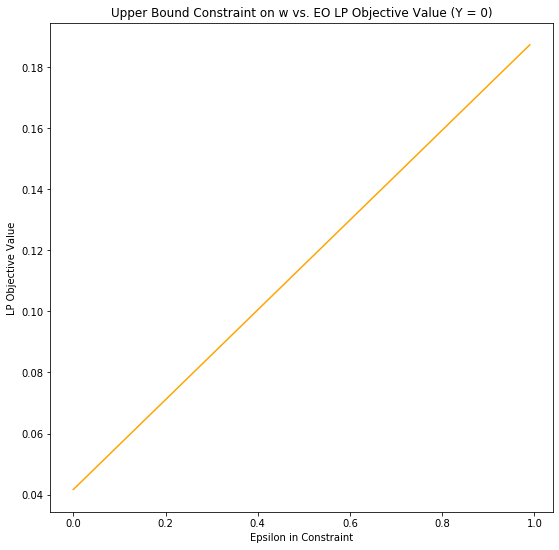

In [17]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, y0_objective_values, 'orange')
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value (Y = 0)')

In [18]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

100
100


In [19]:
print(len(pred_df))
print(len(epsilon_to_weights[0.01]))

4885
4885


In [20]:
# when weights = 0
print(epsilons[0])
print(y0_objective_values[0])

0.0
0.04165051778895367


## Marginal Distributions (Y = 0)

In [21]:
from collections import defaultdict

# Create a dictionary for our table at the end
table_results = defaultdict(list)

In [22]:
# Find the accuracy of our classifier
tp = len(pred_df[(pred_df['predictions'] == 0) & (pred_df['Income Binary'] == 0)])
tn = len(pred_df[(pred_df['predictions'] == 1) & (pred_df['Income Binary'] == 1)])
acc = float(tp + tn)/len(pred_df)

In [23]:
# Find the lowest epsilon value that has a greater than 10% violation
for i in range(len(epsilons)):
    if(y0_objective_values[i] > 0.1):
        lowest_i = i
        break

print(y0_objective_values[lowest_i])
print(epsilons[lowest_i])
table_results['epsilon'].append(epsilons[lowest_i])
table_results['initial_unfairness'].append(y0_objective_values[0])
table_results['acc'].append(acc)

0.10047240695786824
0.4


In [24]:
pred_df['weights'] = epsilon_to_weights[epsilons[lowest_i]].values() # For example, when epsilon = 0.01
pred_df.head(5)

,Unnamed: 0,Unnamed: 0.1,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,...,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,predictions,Income Binary,weights
0,0,5426,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000287
1,1,577,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.000287
2,2,15871,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.000287
3,3,4321,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000287
4,4,2326,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.000123


In [25]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

In [26]:
def l1_dist(dict1, dict2):
    l1_total = 0
    for key in sorted(dict1.keys()):
        diff = abs(dict1[key] - dict2[key])
        l1_total = l1_total + diff
        
    return l1_total

{1.0: 0.6665301944728762, 0.0: 0.33346980552712385}
{0.0: 0.33224155460999244, 1.0: 0.6677584420400472}


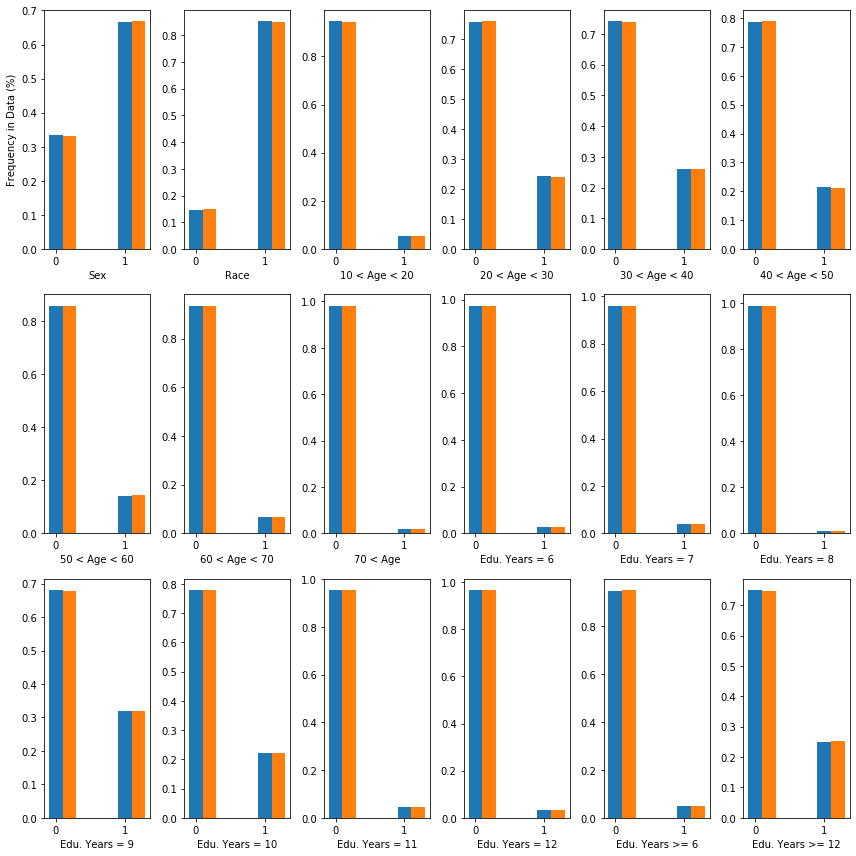

In [27]:
# Get the unweighted and weighted distributions on the data
X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])

print(X_sex_freq)
print(X_sex_marginal)

X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

table_results['sex'].append(l1_dist(X_sex_freq, X_sex_marginal))

# Marginal Distribution on Sex 

X = np.arange(len(X_sex_freq))
plt.figure(figsize=(12,12))
plt.subplot(3,6,1)
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')

X_race_freq = freq_dict(pred_df, 'race')
X_race_marginal = marginalize(pred_df, 'race', pred_df['weights'])
X_race_tuple = graph_tuple(X_race_freq, X_race_marginal)

table_results['race'].append(l1_dist(X_race_freq, X_race_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_race_marginal.keys()))
plt.subplot(3,6,2)
plt.bar(X, X_race_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_race_tuple[1], width = 0.2, align='center')
plt.xlabel('Race')

X_age_freq = freq_dict(pred_df, 'Age (decade)=10')
X_age_marginal = marginalize(pred_df, 'Age (decade)=10', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_10'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,3)
#plt.title("Adult DP Reweighted Marginal Distributions")
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('10 < Age < 20')

X_age_freq = freq_dict(pred_df, 'Age (decade)=20')
X_age_marginal = marginalize(pred_df, 'Age (decade)=20', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_20'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,4)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('20 < Age < 30')

X_age_freq = freq_dict(pred_df, 'Age (decade)=30')
X_age_marginal = marginalize(pred_df, 'Age (decade)=30', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_30'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,5)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('30 < Age < 40')

X_age_freq = freq_dict(pred_df, 'Age (decade)=40')
X_age_marginal = marginalize(pred_df, 'Age (decade)=40', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_40'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,6)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('40 < Age < 50')

X_age_freq = freq_dict(pred_df, 'Age (decade)=50')
X_age_marginal = marginalize(pred_df, 'Age (decade)=50', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_50'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,7)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('50 < Age < 60')

X_age_freq = freq_dict(pred_df, 'Age (decade)=60')
X_age_marginal = marginalize(pred_df, 'Age (decade)=60', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_60'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,8)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('60 < Age < 70')

X_age_freq = freq_dict(pred_df, 'Age (decade)=>=70')
X_age_marginal = marginalize(pred_df, 'Age (decade)=>=70', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_70'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,9)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('70 < Age')

# Got tired of doing this manually
X_education_dict = {}
edu_string = 'Education Years=' 

for i in range(6,13):
    feature = edu_string + str(i)
    X_edu_freq = freq_dict(pred_df, feature)
    X_edu_marginal = marginalize(pred_df, feature, pred_df['weights'])
    X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)
    X_education_dict[feature] = [X_edu_marginal.keys(), X_edu_tuple]
    
    table_label = 'edu' + str(i)
    # print(table_label)
    table_results[table_label].append(l1_dist(X_edu_freq, X_edu_marginal))

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=6'][0]))
plt.subplot(3,6,10)
plt.bar(X, X_education_dict['Education Years=6'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=6'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 6')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=7'][0]))
plt.subplot(3,6,11)
plt.bar(X, X_education_dict['Education Years=7'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=7'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 7')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=8'][0]))
plt.subplot(3,6,12)
plt.bar(X, X_education_dict['Education Years=8'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=8'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 8')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=9'][0]))
plt.subplot(3,6,13)
plt.bar(X, X_education_dict['Education Years=9'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=9'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 9')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=10'][0]))
plt.subplot(3,6,14)
plt.bar(X, X_education_dict['Education Years=10'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=10'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 10')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=11'][0]))
plt.subplot(3,6,15)
plt.bar(X, X_education_dict['Education Years=11'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=11'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 11')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=12'][0]))
plt.subplot(3,6,16)
plt.bar(X, X_education_dict['Education Years=12'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=12'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 12')

X_edu_freq = freq_dict(pred_df, 'Education Years=<6')
X_edu_marginal = marginalize(pred_df, 'Education Years=<6', pred_df['weights'])
X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)

table_results['edu_>6'].append(l1_dist(X_edu_freq, X_edu_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_edu_marginal.keys()))
plt.subplot(3,6,17)
plt.bar(X, X_edu_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_edu_tuple[1], width = 0.2, align='center')
plt.xlabel('Edu. Years >= 6')

X_edu_freq = freq_dict(pred_df, 'Education Years=>12')
X_edu_marginal = marginalize(pred_df, 'Education Years=>12', pred_df['weights'])
X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)

table_results['edu_>12'].append(l1_dist(X_edu_freq, X_edu_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_edu_marginal.keys()))
plt.subplot(3,6,18)
plt.bar(X, X_edu_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_edu_tuple[1], width = 0.2, align='center')
plt.xlabel('Edu. Years >= 12')
plt.tight_layout()
plt.savefig("./../../part1_results/{}/{}_adult_EO_Y0".format(algorithm_used, algorithm_used))
plt.show()

## Experiment with Linear Program (Y = 1)
Experiment with setting the constraints as: $$w_i \leq \frac{(1 + \epsilon)}{n}$$ and $$\frac{(1 - \epsilon)}{n} \leq w_i$$ where n is the number of samples in the data.

In [28]:
epsilon_granule = 0.01

lower_bounds = []
upper_bounds = []
y1_objective_values = []
dist_weights = []
epsilons = []

# Iterate over constraints
for i in range(0, 100):
  epsilon = epsilon_granule * i
  lower_bound = (1 - epsilon)/(len(f_X))
  upper_bound = (1 + epsilon)/(len(f_X))
  model, weights = EO_linear_prog(f_X, lower_bound, upper_bound, 1)
  y1_objective_values.append(pulp.value(model.objective))
  epsilons.append(epsilon)
  lower_bounds.append(lower_bound)
  upper_bounds.append(upper_bound)
  dist_weights.append(weights)

Text(0.5, 1.0, 'Upper Bound Constraint on w vs. EO LP Objective Value (Y = 1)')

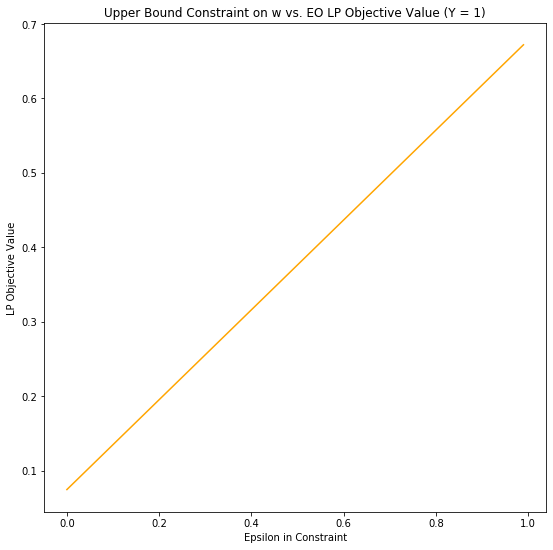

In [29]:
# Plot the constraints vs. objective values
plt.figure(figsize=(9,9))
plt.plot(epsilons, y1_objective_values, 'orange')
plt.xlabel('Epsilon in Constraint')
plt.ylabel('LP Objective Value')
plt.title('Upper Bound Constraint on w vs. EO LP Objective Value (Y = 1)')

In [30]:
print(len(dist_weights))
print(len(epsilons))

epsilon_to_weights = dict()
for i in range(len(epsilons)):
    epsilon_to_weights[epsilons[i]] = weights_dictionary(dist_weights[i])

100
100


In [31]:
# when weights = 0
print(epsilons[0])
print(y1_objective_values[0])

0.0
0.07447960910335799


## Marginal Distributions (Y = 1)

In [32]:
# Find the lowest epsilon value that has a greater than 10% violation
for i in range(len(epsilons)):
    if(y1_objective_values[i] > 0.1):
        lowest_i = i
        break

print(y1_objective_values[lowest_i])
print(epsilons[lowest_i])

table_results['epsilon'].append(epsilons[lowest_i])
table_results['initial_unfairness'].append(y1_objective_values[0])
table_results['acc'].append(acc)

0.10465393691255631
0.05


In [33]:
pred_df['weights'] = epsilon_to_weights[epsilons[lowest_i]].values() # For example, when epsilon = 0.01
pred_df.head(5)

,Unnamed: 0,Unnamed: 0.1,race,sex,Age (decade)=10,Age (decade)=20,Age (decade)=30,Age (decade)=40,Age (decade)=50,Age (decade)=60,...,Education Years=8,Education Years=9,Education Years=10,Education Years=11,Education Years=12,Education Years=<6,Education Years=>12,predictions,Income Binary,weights
0,0,5426,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000215
1,1,577,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0.000215
2,2,15871,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.000215
3,3,4321,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.000215
4,4,2326,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.000194


In [34]:
# Marginal Distribution Function
def marginalize(data, X_attr, weights):
    X_values = data[X_attr]
    key_list = np.unique(X_values)
    X_marginal = {k: 0 for k in key_list}
    for i in range(0, len(X_values)):
        X_marginal[X_values[i]] = X_marginal[X_values[i]] + weights[i]
    return X_marginal

def freq_dict(data, X_attr):
    X_values = data[X_attr].value_counts()
    X_freqs = dict()
    for value in X_values.keys():
        X_freqs[value] = float(X_values[value])/float(len(data))
    return X_freqs

# Returns a tuple of two lists of the items in each dictionary sorted by order of their keys
def graph_tuple(dict1, dict2):
    tuple1 = []
    tuple2 = []
    for key in sorted(dict1.keys()):
        tuple1.append(dict1[key])
        tuple2.append(dict2[key])
    
    return (tuple1, tuple2)

{1.0: 0.6665301944728762, 0.0: 0.33346980552712385}
{0.0: 0.3335005187900051, 1.0: 0.6664995022699973}


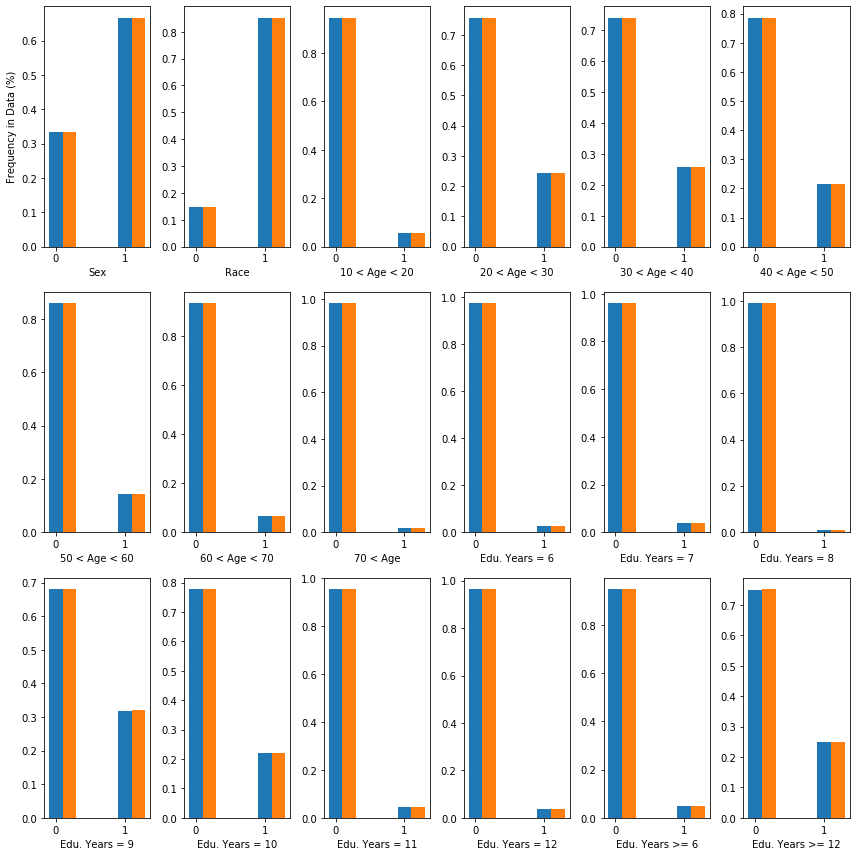

In [35]:
# Get the unweighted and weighted distributions on the data
X_sex_freq = freq_dict(pred_df, 'sex')
X_sex_marginal = marginalize(pred_df, 'sex', pred_df['weights'])

print(X_sex_freq)
print(X_sex_marginal)

X_sex_tuple = graph_tuple(X_sex_freq, X_sex_marginal)

table_results['sex'].append(l1_dist(X_sex_freq, X_sex_marginal))

# Marginal Distribution on Sex 

X = np.arange(len(X_sex_freq))
plt.figure(figsize=(12,12))
plt.subplot(3,6,1)
plt.bar(X, X_sex_tuple[0], width=0.2, align='center')
plt.bar(X+0.2, X_sex_tuple[1], width=0.2, align='center')
plt.xlabel('Sex')
plt.ylabel('Frequency in Data (%)')

X_race_freq = freq_dict(pred_df, 'race')
X_race_marginal = marginalize(pred_df, 'race', pred_df['weights'])
X_race_tuple = graph_tuple(X_race_freq, X_race_marginal)

table_results['race'].append(l1_dist(X_race_freq, X_race_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_race_marginal.keys()))
plt.subplot(3,6,2)
plt.bar(X, X_race_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_race_tuple[1], width = 0.2, align='center')
plt.xlabel('Race')

X_age_freq = freq_dict(pred_df, 'Age (decade)=10')
X_age_marginal = marginalize(pred_df, 'Age (decade)=10', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_10'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,3)
#plt.title("Adult DP Reweighted Marginal Distributions")
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('10 < Age < 20')

X_age_freq = freq_dict(pred_df, 'Age (decade)=20')
X_age_marginal = marginalize(pred_df, 'Age (decade)=20', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_20'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,4)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('20 < Age < 30')

X_age_freq = freq_dict(pred_df, 'Age (decade)=30')
X_age_marginal = marginalize(pred_df, 'Age (decade)=30', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_30'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,5)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('30 < Age < 40')

X_age_freq = freq_dict(pred_df, 'Age (decade)=40')
X_age_marginal = marginalize(pred_df, 'Age (decade)=40', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_40'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,6)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('40 < Age < 50')

X_age_freq = freq_dict(pred_df, 'Age (decade)=50')
X_age_marginal = marginalize(pred_df, 'Age (decade)=50', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_50'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,7)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('50 < Age < 60')

X_age_freq = freq_dict(pred_df, 'Age (decade)=60')
X_age_marginal = marginalize(pred_df, 'Age (decade)=60', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_60'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,8)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('60 < Age < 70')

X_age_freq = freq_dict(pred_df, 'Age (decade)=>=70')
X_age_marginal = marginalize(pred_df, 'Age (decade)=>=70', pred_df['weights'])
X_age_tuple = graph_tuple(X_age_freq, X_age_marginal)

table_results['age_70'].append(l1_dist(X_age_freq, X_age_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_age_marginal.keys()))
plt.subplot(3,6,9)
plt.bar(X, X_age_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_age_tuple[1], width = 0.2, align='center')
plt.xlabel('70 < Age')

# Got tired of doing this manually
X_education_dict = {}
edu_string = 'Education Years=' 

for i in range(6,13):
    feature = edu_string + str(i)
    X_edu_freq = freq_dict(pred_df, feature)
    X_edu_marginal = marginalize(pred_df, feature, pred_df['weights'])
    X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)
    X_education_dict[feature] = [X_edu_marginal.keys(), X_edu_tuple]
    
    table_label = 'edu' + str(i)
    # print(table_label)
    table_results[table_label].append(l1_dist(X_edu_freq, X_edu_marginal))

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=6'][0]))
plt.subplot(3,6,10)
plt.bar(X, X_education_dict['Education Years=6'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=6'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 6')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=7'][0]))
plt.subplot(3,6,11)
plt.bar(X, X_education_dict['Education Years=7'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=7'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 7')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=8'][0]))
plt.subplot(3,6,12)
plt.bar(X, X_education_dict['Education Years=8'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=8'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 8')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=9'][0]))
plt.subplot(3,6,13)
plt.bar(X, X_education_dict['Education Years=9'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=9'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 9')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=10'][0]))
plt.subplot(3,6,14)
plt.bar(X, X_education_dict['Education Years=10'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=10'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 10')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=11'][0]))
plt.subplot(3,6,15)
plt.bar(X, X_education_dict['Education Years=11'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=11'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 11')

# Marginal Distribution on Education 
X = np.asarray(list(X_education_dict['Education Years=12'][0]))
plt.subplot(3,6,16)
plt.bar(X, X_education_dict['Education Years=12'][1][0], width = 0.2, align='center')
plt.bar(X + 0.2, X_education_dict['Education Years=12'][1][1], width = 0.2, align='center')
plt.xlabel('Edu. Years = 12')

X_edu_freq = freq_dict(pred_df, 'Education Years=<6')
X_edu_marginal = marginalize(pred_df, 'Education Years=<6', pred_df['weights'])
X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)

table_results['edu_>6'].append(l1_dist(X_edu_freq, X_edu_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_edu_marginal.keys()))
plt.subplot(3,6,17)
plt.bar(X, X_edu_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_edu_tuple[1], width = 0.2, align='center')
plt.xlabel('Edu. Years >= 6')

X_edu_freq = freq_dict(pred_df, 'Education Years=>12')
X_edu_marginal = marginalize(pred_df, 'Education Years=>12', pred_df['weights'])
X_edu_tuple = graph_tuple(X_edu_freq, X_edu_marginal)

table_results['edu_>12'].append(l1_dist(X_edu_freq, X_edu_marginal))

# Marginal Distribution on Age 
X = np.asarray(list(X_edu_marginal.keys()))
plt.subplot(3,6,18)
plt.bar(X, X_edu_tuple[0], width = 0.2, align='center')
plt.bar(X + 0.2, X_edu_tuple[1], width = 0.2, align='center')
plt.xlabel('Edu. Years >= 12')
plt.tight_layout()
plt.savefig("./../../part1_results/{}/{}_adult_EO_Y1".format(algorithm_used, algorithm_used))
plt.show()

In [36]:
table = pd.DataFrame.from_dict(table_results)
table.to_csv("./../../part1_results/{}/{}_adult_EO_table.csv".format(algorithm_used, algorithm_used))